In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.12.0


In [2]:
batch_size = 128
image_size = 299
test_size = 0.2

# Load Data and division of Data
Total validation images = 16

Total training images = 5216

There is lot of training images compare to validation images and division between these two dataset not in 80:20 ratio.

In below cell, divsion of 80:20 performed after merging all the validation and training images in a list of files.

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 299
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

In [4]:
train = get_training_data('Dataset/train')
test = get_training_data('Dataset/test')
val = get_training_data('Dataset/val')

In [5]:
print(f'Before division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}\n')


combined_array = np.concatenate((train, val))
np.random.shuffle(combined_array)
print(f'Total number of images : training_images + validation_images = {len(combined_array)}\n')

train = combined_array[:int(len(combined_array) * 0.8)]
val = combined_array[int(len(combined_array) * 0.8):]
print(f'After division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}')

Before division of 80:20
Total number of training images = 5216
Total number of validation images = 16

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


# Data Visualization and Pre-processing

<AxesSubplot:ylabel='count'>

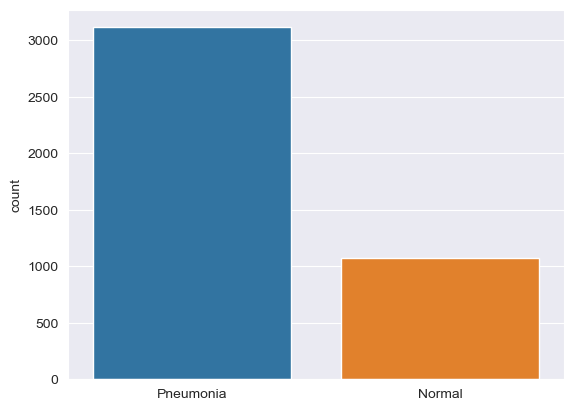

In [6]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning 
x_train = x_train.reshape(-1, image_size, image_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, image_size, image_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, image_size, image_size, 3)
y_test = np.array(y_test)

# Data Augmentation

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    )


datagen.fit(x_train)

In [11]:
x_train.shape

(4185, 299, 299, 3)

# Inception Net Model (After tuning)

All the below parameters are found by experimenting many times while fine-tuning the model. i.e number of the layers that should not be trained, (so 200 layers out of 311 are freezed and will not trained while training), I also tried to add Dense layers but it was not giving good results on test dataset.

In [12]:
base_model2 = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3),include_top=False, weights='imagenet')

for layers in base_model2.layers[:200]:
    layers.trainable = False

model2 = tf.keras.Sequential([
        base_model2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid) 
        ])

model2.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 14,806,337
Non-trainable params: 6,998,496
_________________________________________________________________


Below code block shows, number of layers for base model (Inception) which is 311. and out of 311 layers, I choose to freeze 200 layers while training it means we will not be training those 200 freezed layers.

In [13]:
len(base_model2.layers)

311

In [14]:
checkpoint_cb2 = tf.keras.callbacks.ModelCheckpoint("model1_inceptionNet.h5",
                                                    save_best_only=True)

early_stopping_cb2 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=5, mode = 'min',restore_best_weights=True)

### Train the model

In [15]:
history = model2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    steps_per_epoch = 10,
                    epochs = 10, 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [checkpoint_cb2,early_stopping_cb2])

Epoch 1/10
10/10 [==============================] - 82s 8s/step - loss: 0.3226 - accuracy: 0.8781 - val_loss: 4.2330 - val_accuracy: 0.8720
Epoch 2/10
10/10 [==============================] - 75s 8s/step - loss: 0.1778 - accuracy: 0.9312 - val_loss: 1.1119 - val_accuracy: 0.9284
Epoch 3/10
10/10 [==============================] - 80s 9s/step - loss: 0.1295 - accuracy: 0.9406 - val_loss: 0.7963 - val_accuracy: 0.8949
Epoch 4/10
10/10 [==============================] - 84s 9s/step - loss: 0.1559 - accuracy: 0.9500 - val_loss: 1.0233 - val_accuracy: 0.9140
Epoch 5/10
10/10 [==============================] - 78s 8s/step - loss: 0.1489 - accuracy: 0.9531 - val_loss: 2.5003 - val_accuracy: 0.8577
Epoch 6/10
10/10 [==============================] - 80s 9s/step - loss: 0.1111 - accuracy: 0.9531 - val_loss: 2.0046 - val_accuracy: 0.8118
Epoch 7/10
10/10 [==============================] - 81s 9s/step - loss: 0.1061 - accuracy: 0.9563 - val_loss: 0.5367 - val_accuracy: 0.9436
Epoch 8/10
10/10 [==

Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

In [16]:
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 28s 1s/step - loss: 1.9049 - accuracy: 0.8413
Loss of the model is -  1.904923439025879
20/20 [==============================] - 29s 1s/step - loss: 1.9049 - accuracy: 0.8413
Accuracy of the model is -  84.13461446762085 %


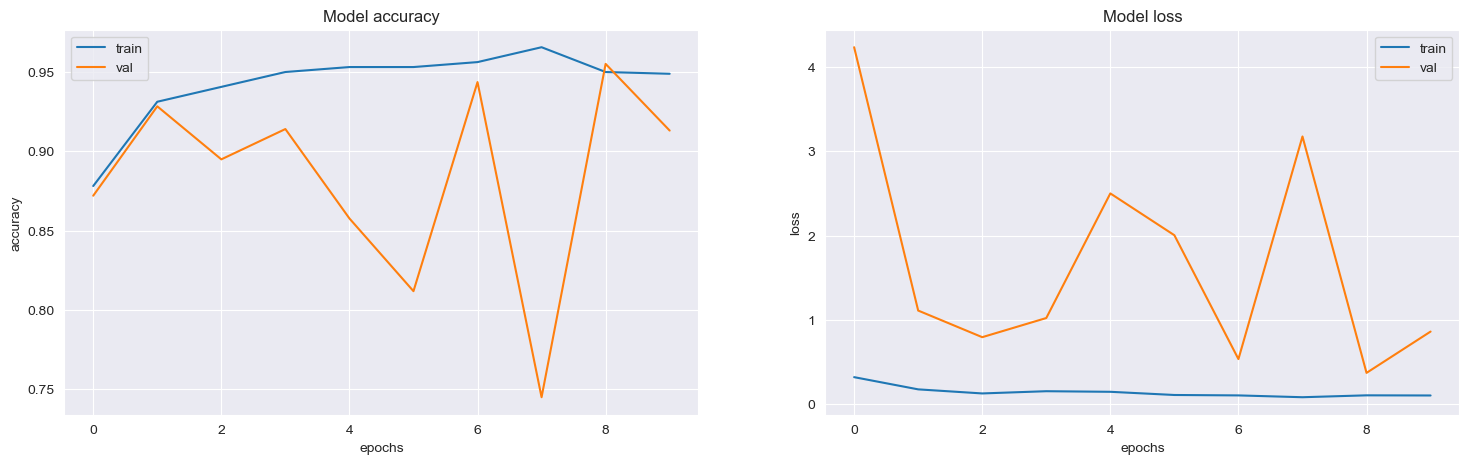

In [17]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [18]:
predictions = (model2.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:-1]

20/20 [==============================] - 29s 1s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.80      0.99      0.89       390
   Normal (Class 1)       0.99      0.59      0.73       234

           accuracy                           0.84       624
          macro avg       0.89      0.79      0.81       624
       weighted avg       0.87      0.84      0.83       624



In [20]:
cm = confusion_matrix(y_test,predictions)
cm

array([[388,   2],
       [ 97, 137]], dtype=int64)

In [21]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

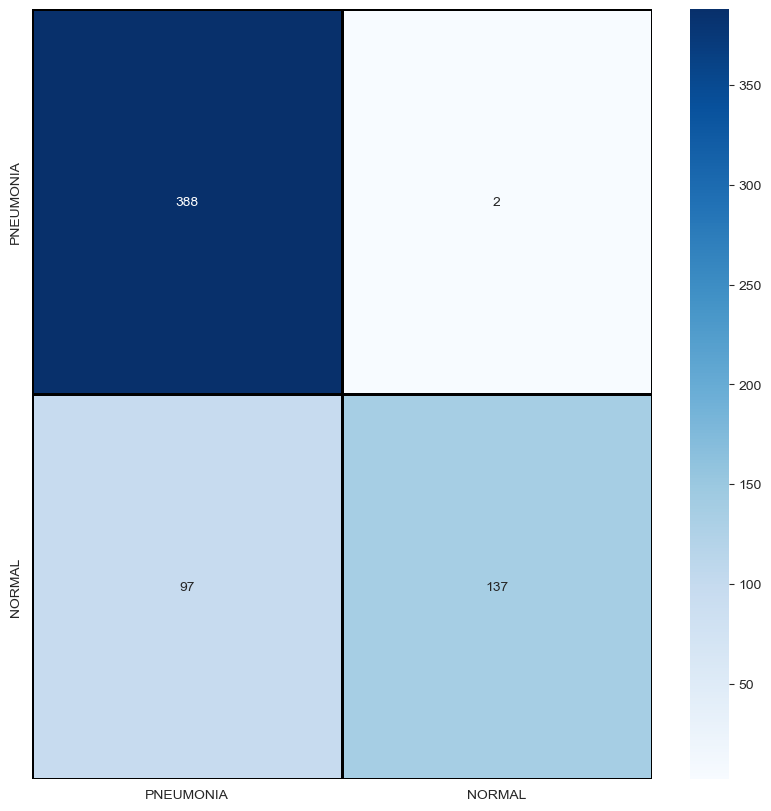

In [22]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [23]:
history = model2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    steps_per_epoch = 10,
                    epochs = 5, 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [checkpoint_cb2,early_stopping_cb2])

Epoch 1/5
10/10 [==============================] - 80s 8s/step - loss: 0.0963 - accuracy: 0.9625 - val_loss: 0.2932 - val_accuracy: 0.9589
Epoch 2/5
10/10 [==============================] - 85s 9s/step - loss: 0.0823 - accuracy: 0.9812 - val_loss: 0.2084 - val_accuracy: 0.9656
Epoch 3/5
10/10 [==============================] - 78s 8s/step - loss: 0.0789 - accuracy: 0.9750 - val_loss: 0.2710 - val_accuracy: 0.9647
Epoch 4/5
10/10 [==============================] - 78s 8s/step - loss: 0.0800 - accuracy: 0.9781 - val_loss: 0.2990 - val_accuracy: 0.9494
Epoch 5/5
10/10 [==============================] - 78s 8s/step - loss: 0.0507 - accuracy: 0.9719 - val_loss: 0.2562 - val_accuracy: 0.9628


Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

In [24]:
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 31s 1s/step - loss: 0.5836 - accuracy: 0.9054
Loss of the model is -  0.5835689902305603
20/20 [==============================] - 29s 1s/step - loss: 0.5836 - accuracy: 0.9054
Accuracy of the model is -  90.54487347602844 %


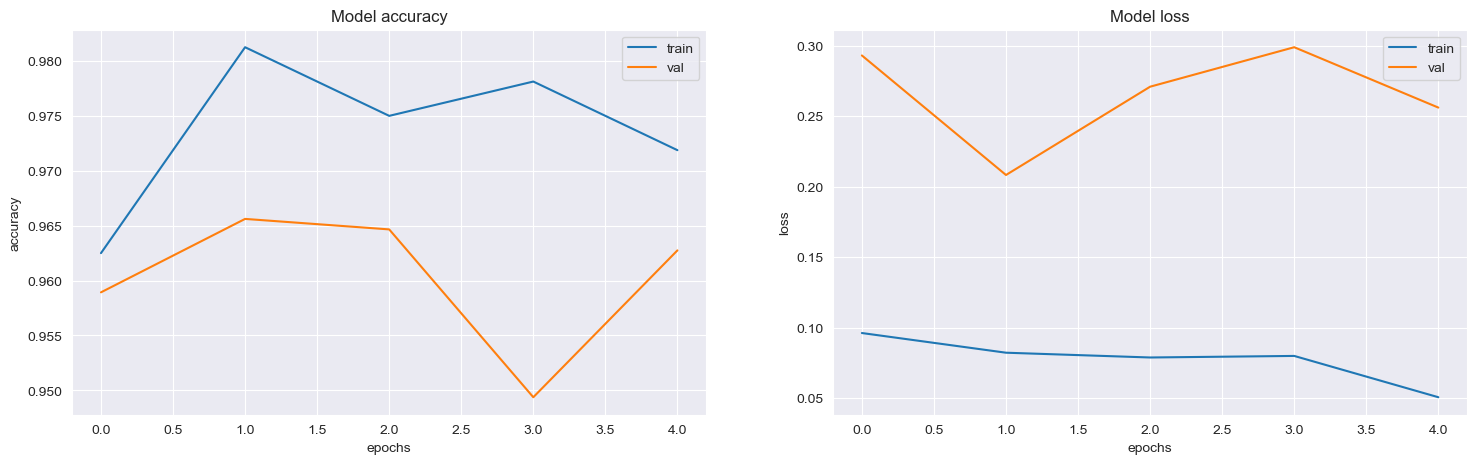

In [25]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [26]:
predictions = (model2.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:-1]

20/20 [==============================] - 29s 1s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [27]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.99      0.93       390
   Normal (Class 1)       0.97      0.77      0.86       234

           accuracy                           0.91       624
          macro avg       0.92      0.88      0.89       624
       weighted avg       0.91      0.91      0.90       624



In [28]:
cm = confusion_matrix(y_test,predictions)
cm

array([[385,   5],
       [ 54, 180]], dtype=int64)

In [29]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

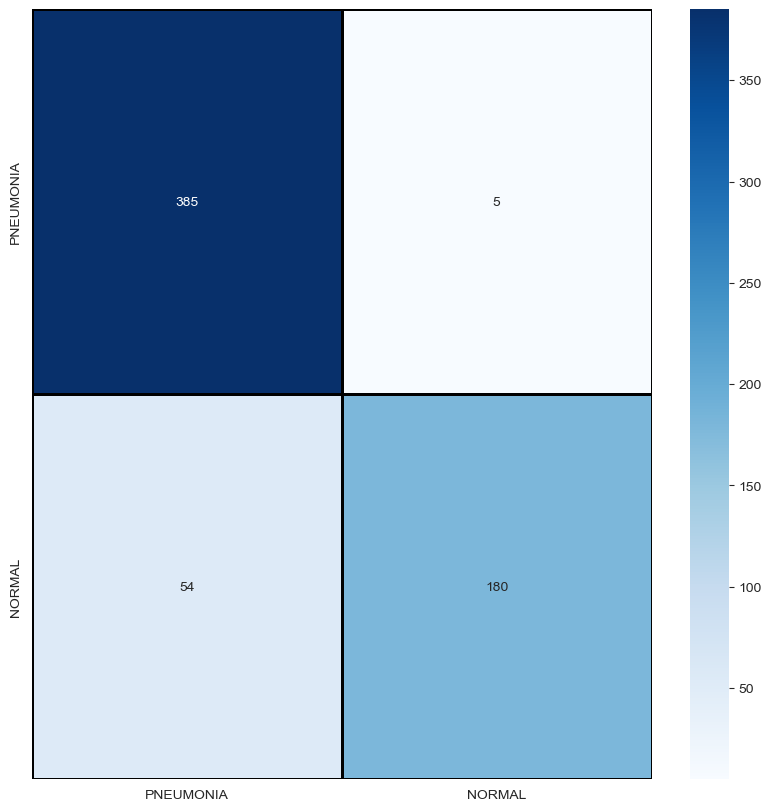

In [30]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [31]:
history = model2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    steps_per_epoch = 10,
                    epochs = 5, 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [checkpoint_cb2,early_stopping_cb2])

Epoch 1/5
10/10 [==============================] - 79s 8s/step - loss: 0.0853 - accuracy: 0.9656 - val_loss: 0.4153 - val_accuracy: 0.9503
Epoch 2/5
10/10 [==============================] - 78s 8s/step - loss: 0.0546 - accuracy: 0.9812 - val_loss: 0.2121 - val_accuracy: 0.9675
Epoch 3/5
10/10 [==============================] - 77s 8s/step - loss: 0.0939 - accuracy: 0.9656 - val_loss: 0.2603 - val_accuracy: 0.9542
Epoch 4/5
10/10 [==============================] - 81s 9s/step - loss: 0.0492 - accuracy: 0.9812 - val_loss: 0.1219 - val_accuracy: 0.9780
Epoch 5/5
10/10 [==============================] - 80s 9s/step - loss: 0.0236 - accuracy: 0.9969 - val_loss: 0.1540 - val_accuracy: 0.9704


Below codes, helps us to visualise the model - loss parameter for training dataset as well as validation dataset while training and model - accuracy for training and validation dataset. all the graphs points recoreded at the end of every epoch.

### Visualise the model performance

In [32]:
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 29s 1s/step - loss: 0.4187 - accuracy: 0.9183
Loss of the model is -  0.4187459349632263
20/20 [==============================] - 29s 1s/step - loss: 0.4187 - accuracy: 0.9183
Accuracy of the model is -  91.82692170143127 %


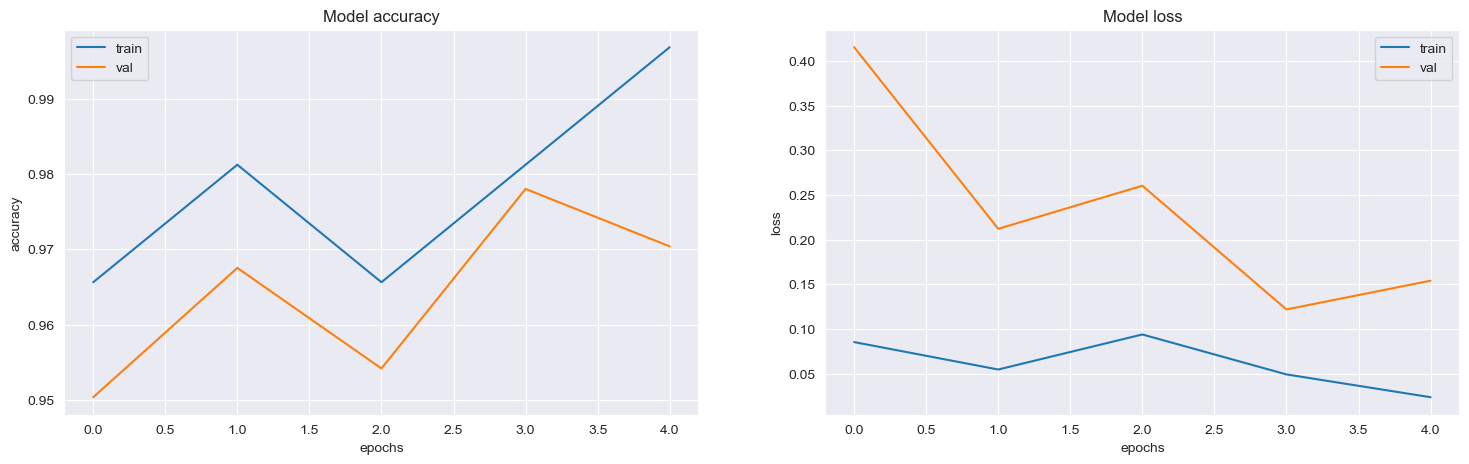

In [33]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [34]:
predictions = (model2.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:-1]

20/20 [==============================] - 28s 1s/step


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.94      0.93       390
   Normal (Class 1)       0.90      0.88      0.89       234

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [36]:
cm = confusion_matrix(y_test,predictions)
cm

array([[366,  24],
       [ 27, 207]], dtype=int64)

In [37]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

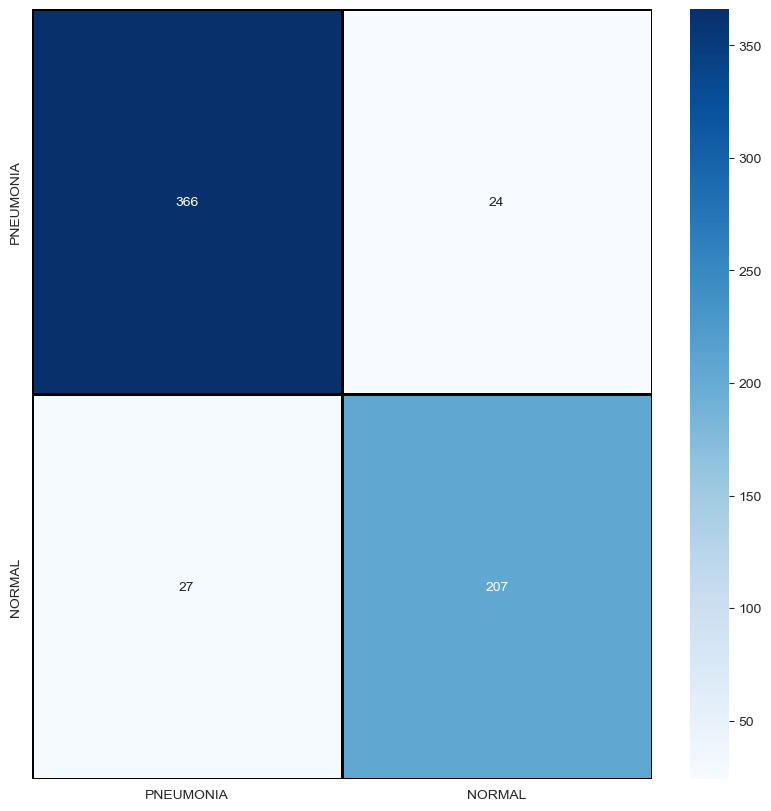

In [38]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)